In [79]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from time import time
from tqdm.notebook import tqdm
import torch.nn.utils.prune as prune

import torch_pruning as tp

import matplotlib.pyplot as plt
import numpy as np
import random
from ptflops import get_model_complexity_info
import copy

seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)  # if you use multi-GPU
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# load dataset

### fashionMNIST image size : LeNet5 모델에 맞게 (1, 32, 32) 로 변환

In [8]:
transform = transforms.Compose([
    transforms.Resize((32,32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,),(0.5,))
])

trainset = torchvision.datasets.FashionMNIST(root = "data", train = True, download = True, transform = transform)
testset = torchvision.datasets.FashionMNIST(root = "data", train = False, download = True, transform = transform)

train_loader = torch.utils.data.DataLoader(dataset = trainset, shuffle = True, batch_size = 32)
test_loader = torch.utils.data.DataLoader(dataset = testset, shuffle = False, batch_size = 32)


label_tags = {
    0:'T-Shirt',
    1:'Trouser',
    2:'Pullover',
    3:'Dress',
    4:'Coat',
    5:'Sandal',
    6:'Shirt',
    7:'Sneaker',
    8:'Bag',
    9:'Ankle Boot'
}

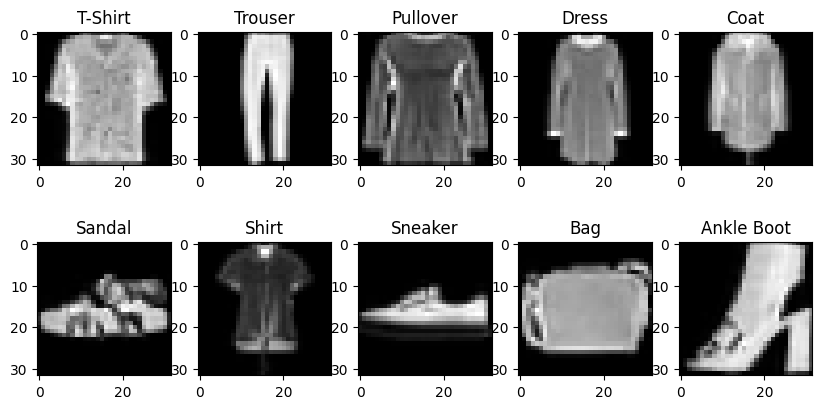

In [9]:
iter_trainloader = iter(train_loader)
imgs, labels = next(iter_trainloader)
imgs_2, labels_2 = next(iter_trainloader)

figure = plt.figure(figsize = (10,5))
rows, cols = (2,5)
for i in range(0, 10):
    img_idxs = np.argwhere(labels == i)[0]
    if img_idxs.shape[0] == 0:
        print('두번째 loader')
        img_idx = np.argwhere(labels_2 == i)[0][0]
    else: 
        img_idx = img_idxs[0]
    figure.add_subplot(rows, cols, i+1)
    plt.title(label_tags[i])
    plt.imshow(imgs[img_idx].squeeze(), cmap = 'grey')
plt.show()

## Model - LeNet5

In [10]:
class LeNet_5(nn.Module):
    def __init__(self):
        super(LeNet_5, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
    
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## train, test, pruning, fine-tuning, quantization 함수 정의

## train

In [12]:
def original_train(model):
    print('original train 시작...')
    epochs = 5
    learning_rate = 1e-3
    total_samples = 0

    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr = learning_rate)
    
    for e in range(epochs):
        #print("Starting epoch", e)
        total_loss = 0
        
        for idx, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            output = model(images)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
    
            total_samples += labels.size(0)
            total_loss += loss.item()
    
            #if idx % 100 == 0:
                # print(f"idx {idx}, Runnning loss: {total_loss / len(train_loader)}")
        #print(f"epoch {e} : total_loss : {total_loss}")

    
    return model

## test

In [13]:
def test(model):
    correct = 0
    total_samples = 0
    total_time = 0
    model.eval()
    
    with torch.no_grad():
        for idx, (imgs, labels) in enumerate(test_loader):
            imgs = imgs.to(device)
            labels = labels.to(device)
            start_time = time()
            
            output = model(imgs)
            end_time = time()

            elapsed_time = end_time - start_time
            total_time += elapsed_time
            
            _, indices = output.max(1)
            correct += (labels == indices).sum()
            total_samples += indices.size(0)
            
        acc = correct/total_samples * 100
        avg_time_per_sample = total_time / total_samples * 1000000
        
    return acc,avg_time_per_sample

In [71]:
def test_onCPU(model):
    correct = 0
    total_samples = 0
    total_time = 0
    model.eval()
    
    with torch.no_grad():
        for idx, (imgs, labels) in enumerate(test_loader):
            # imgs = imgs.to(device)
            # labels = labels.to(device)
            start_time = time()
            output = model(imgs)
            end_time = time()

            elapsed_time = end_time - start_time
            total_time += elapsed_time

            _, indices = output.max(1)
            correct += (labels == indices).sum()
            total_samples += indices.size(0)
            
        acc = correct/total_samples * 100
        avg_time_per_sample = total_time / total_samples
        
    return acc,avg_time_per_sample

## pruning

In [27]:
def pruning(model, ratio):
    example_inputs = torch.randn(1, 1, 32, 32)
    example_inputs = example_inputs.to(device)
    acc_list = []
    param_list = []
    mmac_list = []
    
    #pruning 기준: 가중치의 절댓값 기준 작은 채널부터 ratio에 따라 제거
    imp = tp.importance.MagnitudeImportance(p=2, group_reduction='mean')
    
    
    ignored_layers = []
    for m in model.modules(): #마지막 fc layer는 pruning에서 제외
        if isinstance(m, torch.nn.Linear) and m.out_features == 10:
            ignored_layers.append(m) 
    
            

    iterative_steps = 5 
    pruner = tp.pruner.MagnitudePruner(
        model, 
        example_inputs, 
        global_pruning=False, 
        importance=imp, 
        iterative_steps=iterative_steps, #iterative하게 조금씩 pruning
        pruning_ratio=ratio,  #pruning ratio
        ignored_layers=ignored_layers,
    )
    
    base_macs, base_nparams = tp.utils.count_ops_and_params(model, example_inputs)
    base_acc, base_inference_time = test(model)

    acc_list.append(base_acc)
    param_list.append(base_nparams)
    mmac_list.append(base_macs)
    # print("======================================")
    # print("======================================")
    # print("======================================")
    # print(base_macs, base_nparams, base_acc, base_inference_time)
    # print("======================================")
    # print("======================================")
    # print("======================================")
    
    
    
    for i in range(iterative_steps):
        print(i)
        pruner.step()
        
        macs, nparams = tp.utils.count_ops_and_params(model, example_inputs)
        acc, inference_time = test(model)
        # for m in model.named_parameters():
        #     print(m[0])
        #     print(m[1].shape)
            
        print("======================================")
        print(
            "  Iter %d/%d, Params: %.2f  => %.2f "
            % (i+1, iterative_steps, base_nparams , nparams)
        )
        print(
            "  Iter %d/%d, MACs: %.2f  => %.2f "
            % (i+1, iterative_steps, base_macs, macs)
        )
        print(
            "  Iter %d/%d, pruning만 acc: %.2f  => %.2f "
            % (i+1, iterative_steps, base_acc, acc)
        )
        print(
            "  Iter %d/%d, inference time: %.2fμs  => %.2fμs"
            % (i+1, iterative_steps, base_inference_time, inference_time)
        )
        acc_list.append(acc)
        param_list.append(nparams)
        mmac_list.append(macs)
    
        print("======================================\n\n")
    return model, acc_list, param_list, mmac_list, inference_time
    
        

## fine-tuning

In [25]:
def fine_tuning(model):
    epochs = 5
    learning_rate = 1e-4
    total_samples = 0
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr = learning_rate)
    
    for e in range(epochs):
        #print("Starting epoch", e)
        total_loss = 0
        
        for idx, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            output = model(images)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
    
            total_samples += labels.size(0)
            total_loss += loss.item()
    
            # if idx % 100 == 0:
            #     print(f"idx {idx}, Runnning loss: {total_loss / len(train_loader)}")
        # print(f"epoch {e} : total_loss : {total_loss}")
    
    return model

## pruning + fine-tuning

In [28]:
def pruning_finetuning(model, ratio):
    acc_list = []
    param_list = []
    mmac_list = []

    #기존 pruning
    example_inputs = torch.randn(1, 1, 32, 32)
    example_inputs = example_inputs.to(device)
    
    imp = tp.importance.MagnitudeImportance(p=2, group_reduction='mean')
    
    ignored_layers = []
    for m in model.modules():
        if isinstance(m, torch.nn.Linear) and m.out_features == 10:
            ignored_layers.append(m) 
    
            
    iterative_steps = 5 
    pruner = tp.pruner.MagnitudePruner(
        model, 
        example_inputs, 
        global_pruning=False, 
        importance=imp, 
        iterative_steps=iterative_steps, 
        pruning_ratio=ratio, 
        ignored_layers=ignored_layers,
    )
    
    base_macs, base_nparams = tp.utils.count_ops_and_params(model, example_inputs)
    base_acc, base_inference_time = test(model)
    acc_list.append(base_acc)
    param_list.append(base_nparams)
    mmac_list.append(base_macs)
    
    
    
    for i in range(iterative_steps):
        print(i)
        pruner.step()
        # for m in model.named_parameters():
        #     print(m[0])
        #     print(m[1].shape)
        
        macs, nparams = tp.utils.count_ops_and_params(model, example_inputs)
        acc, inference_time = test(model)
        
        print("======================================")
        print(
            "  Iter %d/%d, Params: %.2f  => %.2f "
            % (i+1, iterative_steps, base_nparams , nparams)
        )
        print(
            "  Iter %d/%d, MACs: %.2f  => %.2f "
            % (i+1, iterative_steps, base_macs, macs)
        )

        
        #pruning한 모델 fine-tuning
        model = fine_tuning(model)
        acc, inference_time = test(model)
        print(
            "  Iter %d/%d, tuning 후 acc: %.2f  => %.2f "
            % (i+1, iterative_steps, base_acc, acc)
        )
        print(
            "  Iter %d/%d, inference time: %.2fμs  => %.2fμs"
            % (i+1, iterative_steps, base_inference_time, inference_time)
        )
        
        acc_list.append(acc)
        param_list.append(nparams)
        mmac_list.append(macs)
        print("======================================")
        
    return model, acc_list, param_list, mmac_list, inference_time

## quantization

In [53]:
def quantize_qint8(net):
    example_inputs = torch.randn(1, 1, 32, 32)
    model_dynamic_quantized = torch.quantization.quantize_dynamic(
        net.to('cpu'), qconfig_spec={torch.nn.Linear}, dtype=torch.qint8
    ).to('cpu')
    quantize_macs, quantize_nparams = tp.utils.count_ops_and_params(model_dynamic_quantized, example_inputs.to('cpu'))
    print('Quantize')
    print('\tMACs: %f M' % (quantize_macs/1e6))
    print('\tParams: %f M' % (quantize_nparams/1e6))
    print(model_dynamic_quantized)

    return model_dynamic_quantized

## 기본 모델 train 후 test

In [26]:
origin_model = LeNet_5().to(device)
origin_model = original_train(origin_model)

acc, inference_time = test(origin_model)
print(f'accuracy: {acc.item():.3f}\ninference time: {inference_time:.3f}μs')

original train 시작...
accuracy: 89.740
inference time: 21.748μs


# pruning ratio : 50%

## 50% pruning (fine-tune 안함)

In [29]:
model = copy.deepcopy(origin_model)

_model_50, _acc_50, _params_50, _mmac_50, _inference_time_50 = pruning(model, 0.5)

0
  Iter 1/5, Params: 61706.00  => 48737.00 
  Iter 1/5, MACs: 429342.00  => 330483.00 
  Iter 1/5, pruning만 acc: 89.74  => 87.43 
  Iter 1/5, inference time: 23.22μs  => 22.26μs


1
  Iter 2/5, Params: 61706.00  => 37391.00 
  Iter 2/5, MACs: 429342.00  => 243147.00 
  Iter 2/5, pruning만 acc: 89.74  => 72.91 
  Iter 2/5, inference time: 23.22μs  => 21.25μs


2
  Iter 3/5, Params: 61706.00  => 29919.00 
  Iter 3/5, MACs: 429342.00  => 225576.00 
  Iter 3/5, pruning만 acc: 89.74  => 69.77 
  Iter 3/5, inference time: 23.22μs  => 20.92μs


3
  Iter 4/5, Params: 61706.00  => 21194.00 
  Iter 4/5, MACs: 429342.00  => 153236.00 
  Iter 4/5, pruning만 acc: 89.74  => 62.64 
  Iter 4/5, inference time: 23.22μs  => 18.71μs


4
  Iter 5/5, Params: 61706.00  => 15738.00 
  Iter 5/5, MACs: 429342.00  => 140156.00 
  Iter 5/5, pruning만 acc: 89.74  => 53.19 
  Iter 5/5, inference time: 23.22μs  => 19.45μs




## pruning 50% -> fine-tuning 까지

In [31]:
model = copy.deepcopy(origin_model)

model_50, acc_50, params_50, mmac_50, inference_time_50 = pruning_finetuning(model, 0.5)

0
  Iter 1/5, Params: 61706.00  => 48737.00 
  Iter 1/5, MACs: 429342.00  => 330483.00 
  Iter 1/5, tuning 후 acc: 89.74  => 90.83 
  Iter 1/5, inference time: 23.41μs  => 23.05μs
1
  Iter 2/5, Params: 61706.00  => 37391.00 
  Iter 2/5, MACs: 429342.00  => 243147.00 
  Iter 2/5, tuning 후 acc: 89.74  => 89.87 
  Iter 2/5, inference time: 23.41μs  => 22.52μs
2
  Iter 3/5, Params: 61706.00  => 29919.00 
  Iter 3/5, MACs: 429342.00  => 225576.00 
  Iter 3/5, tuning 후 acc: 89.74  => 90.19 
  Iter 3/5, inference time: 23.41μs  => 24.38μs
3
  Iter 4/5, Params: 61706.00  => 21194.00 
  Iter 4/5, MACs: 429342.00  => 153236.00 
  Iter 4/5, tuning 후 acc: 89.74  => 89.86 
  Iter 4/5, inference time: 23.41μs  => 23.32μs
4
  Iter 5/5, Params: 61706.00  => 15738.00 
  Iter 5/5, MACs: 429342.00  => 140156.00 
  Iter 5/5, tuning 후 acc: 89.74  => 89.41 
  Iter 5/5, inference time: 23.41μs  => 22.17μs


In [37]:
model_50

LeNet_5(
  (conv1): Conv2d(1, 3, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(3, 8, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=200, out_features=60, bias=True)
  (fc2): Linear(in_features=60, out_features=42, bias=True)
  (fc3): Linear(in_features=42, out_features=10, bias=True)
)

In [34]:
def make_list(m):
    return [i.item() for i in m]

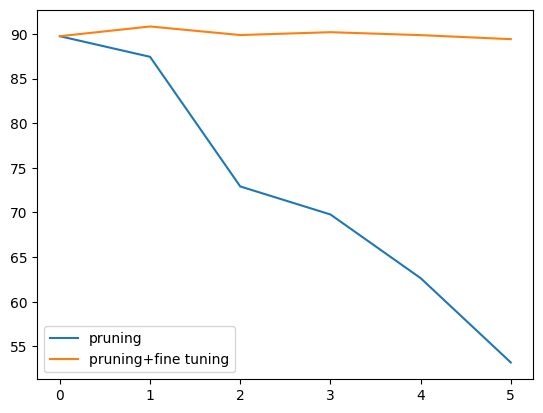

In [35]:
a = list(range(6))
b = make_list(_acc_50)

x = list(range(6))
y = make_list(acc_50)

plt.plot(a,b, label = 'pruning')
plt.plot(x,y, label = 'pruning+fine tuning')
plt.legend()

plt.show()

# pruning ratio : 60%

## pruning (fine-tune 안함) 60%

In [38]:
model = copy.deepcopy(origin_model)

_model_60, _acc_60, _params_60, _mmac_60, _inference_time_60 = pruning(model, 0.6)

0
  Iter 1/5, Params: 61706.00  => 47227.00 
  Iter 1/5, MACs: 429342.00  => 328973.00 
  Iter 1/5, pruning만 acc: 89.74  => 87.43 
  Iter 1/5, inference time: 21.33μs  => 19.66μs


1
  Iter 2/5, Params: 61706.00  => 35143.00 
  Iter 2/5, MACs: 429342.00  => 240899.00 
  Iter 2/5, pruning만 acc: 89.74  => 72.46 
  Iter 2/5, inference time: 21.33μs  => 20.69μs


2
  Iter 3/5, Params: 61706.00  => 24535.00 
  Iter 3/5, MACs: 429342.00  => 164201.00 
  Iter 3/5, pruning만 acc: 89.74  => 68.50 
  Iter 3/5, inference time: 21.33μs  => 19.33μs


3
  Iter 4/5, Params: 61706.00  => 16297.00 
  Iter 4/5, MACs: 429342.00  => 140715.00 
  Iter 4/5, pruning만 acc: 89.74  => 54.93 
  Iter 4/5, inference time: 21.33μs  => 17.85μs


4
  Iter 5/5, Params: 61706.00  => 9563.00 
  Iter 5/5, MACs: 429342.00  => 82741.00 
  Iter 5/5, pruning만 acc: 89.74  => 33.32 
  Iter 5/5, inference time: 21.33μs  => 19.15μs




## fine-tuning 까지 60%

In [39]:
model = copy.deepcopy(origin_model)

model_60, acc_60, params_60, mmac_60, inference_time_60 = pruning_finetuning(model, 0.6)

0
  Iter 1/5, Params: 61706.00  => 47227.00 
  Iter 1/5, MACs: 429342.00  => 328973.00 
  Iter 1/5, tuning 후 acc: 89.74  => 90.71 
  Iter 1/5, inference time: 22.37μs  => 24.84μs
1
  Iter 2/5, Params: 61706.00  => 35143.00 
  Iter 2/5, MACs: 429342.00  => 240899.00 
  Iter 2/5, tuning 후 acc: 89.74  => 90.00 
  Iter 2/5, inference time: 22.37μs  => 21.03μs
2
  Iter 3/5, Params: 61706.00  => 24535.00 
  Iter 3/5, MACs: 429342.00  => 164201.00 
  Iter 3/5, tuning 후 acc: 89.74  => 89.66 
  Iter 3/5, inference time: 22.37μs  => 21.63μs
3
  Iter 4/5, Params: 61706.00  => 16297.00 
  Iter 4/5, MACs: 429342.00  => 140715.00 
  Iter 4/5, tuning 후 acc: 89.74  => 89.28 
  Iter 4/5, inference time: 22.37μs  => 24.11μs
4
  Iter 5/5, Params: 61706.00  => 9563.00 
  Iter 5/5, MACs: 429342.00  => 82741.00 
  Iter 5/5, tuning 후 acc: 89.74  => 86.79 
  Iter 5/5, inference time: 22.37μs  => 21.19μs


In [40]:
model_60

LeNet_5(
  (conv1): Conv2d(1, 2, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(2, 6, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=150, out_features=48, bias=True)
  (fc2): Linear(in_features=48, out_features=33, bias=True)
  (fc3): Linear(in_features=33, out_features=10, bias=True)
)

# pruning ratio : 70%

## pruning (fine-tune 안함) 70%

In [41]:
model = copy.deepcopy(origin_model)

_model_70, _acc_70, _params_70, _mmac_70, _inference_time_70 = pruning(model, 0.7)

0
  Iter 1/5, Params: 61706.00  => 43564.00 
  Iter 1/5, MACs: 429342.00  => 312736.00 
  Iter 1/5, pruning만 acc: 89.74  => 86.92 
  Iter 1/5, inference time: 21.69μs  => 23.75μs


1
  Iter 2/5, Params: 61706.00  => 30781.00 
  Iter 2/5, MACs: 429342.00  => 226438.00 
  Iter 2/5, pruning만 acc: 89.74  => 69.89 
  Iter 2/5, inference time: 21.69μs  => 24.05μs


2
  Iter 3/5, Params: 61706.00  => 20206.00 
  Iter 3/5, MACs: 429342.00  => 152248.00 
  Iter 3/5, pruning만 acc: 89.74  => 61.70 
  Iter 3/5, inference time: 21.69μs  => 21.81μs


3
  Iter 4/5, Params: 61706.00  => 11839.00 
  Iter 4/5, MACs: 429342.00  => 90166.00 
  Iter 4/5, pruning만 acc: 89.74  => 34.24 
  Iter 4/5, inference time: 21.69μs  => 23.81μs


4
  Iter 5/5, Params: 61706.00  => 4951.00 
  Iter 5/5, MACs: 429342.00  => 36789.00 
  Iter 5/5, pruning만 acc: 89.74  => 18.67 
  Iter 5/5, inference time: 21.69μs  => 20.39μs




## fine-tuning 까지 70%

In [42]:
model = copy.deepcopy(origin_model)

model_70, acc_70, params_70, mmac_70, inference_time_70 = pruning_finetuning(model, 0.7)

0
  Iter 1/5, Params: 61706.00  => 43564.00 
  Iter 1/5, MACs: 429342.00  => 312736.00 
  Iter 1/5, tuning 후 acc: 89.74  => 90.69 
  Iter 1/5, inference time: 22.79μs  => 20.11μs
1
  Iter 2/5, Params: 61706.00  => 30781.00 
  Iter 2/5, MACs: 429342.00  => 226438.00 
  Iter 2/5, tuning 후 acc: 89.74  => 89.67 
  Iter 2/5, inference time: 22.79μs  => 22.44μs
2
  Iter 3/5, Params: 61706.00  => 20206.00 
  Iter 3/5, MACs: 429342.00  => 152248.00 
  Iter 3/5, tuning 후 acc: 89.74  => 89.48 
  Iter 3/5, inference time: 22.79μs  => 23.85μs
3
  Iter 4/5, Params: 61706.00  => 11839.00 
  Iter 4/5, MACs: 429342.00  => 90166.00 
  Iter 4/5, tuning 후 acc: 89.74  => 87.15 
  Iter 4/5, inference time: 22.79μs  => 20.64μs
4
  Iter 5/5, Params: 61706.00  => 4951.00 
  Iter 5/5, MACs: 429342.00  => 36789.00 
  Iter 5/5, tuning 후 acc: 89.74  => 82.65 
  Iter 5/5, inference time: 22.79μs  => 16.02μs


In [47]:
model_70

LeNet_5(
  (conv1): Conv2d(1, 1, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(1, 4, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=100, out_features=36, bias=True)
  (fc2): Linear(in_features=36, out_features=25, bias=True)
  (fc3): Linear(in_features=25, out_features=10, bias=True)
)

# pruning ratio : 80%

## pruning (fine-tune 안함) 80%

In [43]:
model = copy.deepcopy(origin_model)

_model_80, _acc_80, _params_80, _mmac_80, _inference_time_80 = pruning(model, 0.8)

0
  Iter 1/5, Params: 61706.00  => 42148.00 
  Iter 1/5, MACs: 429342.00  => 311320.00 
  Iter 1/5, pruning만 acc: 89.74  => 86.85 
  Iter 1/5, inference time: 18.14μs  => 17.62μs


1
  Iter 2/5, Params: 61706.00  => 26699.00 
  Iter 2/5, MACs: 429342.00  => 212257.00 
  Iter 2/5, pruning만 acc: 89.74  => 71.46 
  Iter 2/5, inference time: 18.14μs  => 19.05μs


2
  Iter 3/5, Params: 61706.00  => 16297.00 
  Iter 3/5, MACs: 429342.00  => 140715.00 
  Iter 3/5, pruning만 acc: 89.74  => 54.92 
  Iter 3/5, inference time: 18.14μs  => 16.49μs


3
  Iter 4/5, Params: 61706.00  => 7355.00 
  Iter 4/5, MACs: 429342.00  => 75384.00 
  Iter 4/5, pruning만 acc: 89.74  => 23.65 
  Iter 4/5, inference time: 18.14μs  => 16.77μs


4
  Iter 5/5, Params: 61706.00  => 2406.00 
  Iter 5/5, MACs: 429342.00  => 31570.00 
  Iter 5/5, pruning만 acc: 89.74  => 14.24 
  Iter 5/5, inference time: 18.14μs  => 17.96μs




## fine-tuning 까지 80%

In [44]:
model = copy.deepcopy(origin_model)

model_80, acc_80, params_80, mmac_80, inference_time_80 = pruning_finetuning(model, 0.8)

0
  Iter 1/5, Params: 61706.00  => 42148.00 
  Iter 1/5, MACs: 429342.00  => 311320.00 
  Iter 1/5, tuning 후 acc: 89.74  => 90.74 
  Iter 1/5, inference time: 19.01μs  => 18.77μs
1
  Iter 2/5, Params: 61706.00  => 26699.00 
  Iter 2/5, MACs: 429342.00  => 212257.00 
  Iter 2/5, tuning 후 acc: 89.74  => 89.64 
  Iter 2/5, inference time: 19.01μs  => 21.10μs
2
  Iter 3/5, Params: 61706.00  => 16297.00 
  Iter 3/5, MACs: 429342.00  => 140715.00 
  Iter 3/5, tuning 후 acc: 89.74  => 89.26 
  Iter 3/5, inference time: 19.01μs  => 18.91μs
3
  Iter 4/5, Params: 61706.00  => 7355.00 
  Iter 4/5, MACs: 429342.00  => 75384.00 
  Iter 4/5, tuning 후 acc: 89.74  => 85.85 
  Iter 4/5, inference time: 19.01μs  => 17.56μs
4
  Iter 5/5, Params: 61706.00  => 2406.00 
  Iter 5/5, MACs: 429342.00  => 31570.00 
  Iter 5/5, tuning 후 acc: 89.74  => 79.77 
  Iter 5/5, inference time: 19.01μs  => 18.26μs


In [48]:
model_80

LeNet_5(
  (conv1): Conv2d(1, 1, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(1, 3, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=75, out_features=23, bias=True)
  (fc2): Linear(in_features=23, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=10, bias=True)
)

# pruning ratio : 90%

## pruning (fine-tune 안함) 90%

In [45]:
model = copy.deepcopy(origin_model)

_model_90, _acc_90, _params_90, _mmac_90, _inference_time_90 = pruning(model, 0.9)

0
  Iter 1/5, Params: 61706.00  => 40787.00 
  Iter 1/5, MACs: 429342.00  => 256642.00 
  Iter 1/5, pruning만 acc: 89.74  => 75.13 
  Iter 1/5, inference time: 19.60μs  => 20.01μs


1
  Iter 2/5, Params: 61706.00  => 24535.00 
  Iter 2/5, MACs: 429342.00  => 164201.00 
  Iter 2/5, pruning만 acc: 89.74  => 68.83 
  Iter 2/5, inference time: 19.60μs  => 18.34μs


2
  Iter 3/5, Params: 61706.00  => 12607.00 
  Iter 3/5, MACs: 429342.00  => 90934.00 
  Iter 3/5, pruning만 acc: 89.74  => 35.09 
  Iter 3/5, inference time: 19.60μs  => 18.85μs


3
  Iter 4/5, Params: 61706.00  => 4485.00 
  Iter 4/5, MACs: 429342.00  => 36323.00 
  Iter 4/5, pruning만 acc: 89.74  => 17.15 
  Iter 4/5, inference time: 19.60μs  => 18.51μs


4
  Iter 5/5, Params: 61706.00  => 524.00 
  Iter 5/5, MACs: 429342.00  => 24340.00 
  Iter 5/5, pruning만 acc: 89.74  => 10.00 
  Iter 5/5, inference time: 19.60μs  => 18.24μs




## fine-tuning 까지 90%

In [46]:
model = copy.deepcopy(origin_model)

model_90, acc_90, params_90, mmac_90, inference_time_90 = pruning_finetuning(model, 0.9)

0
  Iter 1/5, Params: 61706.00  => 40787.00 
  Iter 1/5, MACs: 429342.00  => 256642.00 
  Iter 1/5, tuning 후 acc: 89.74  => 89.76 
  Iter 1/5, inference time: 20.23μs  => 21.49μs
1
  Iter 2/5, Params: 61706.00  => 24535.00 
  Iter 2/5, MACs: 429342.00  => 164201.00 
  Iter 2/5, tuning 후 acc: 89.74  => 89.61 
  Iter 2/5, inference time: 20.23μs  => 21.67μs
2
  Iter 3/5, Params: 61706.00  => 12607.00 
  Iter 3/5, MACs: 429342.00  => 90934.00 
  Iter 3/5, tuning 후 acc: 89.74  => 87.19 
  Iter 3/5, inference time: 20.23μs  => 19.55μs
3
  Iter 4/5, Params: 61706.00  => 4485.00 
  Iter 4/5, MACs: 429342.00  => 36323.00 
  Iter 4/5, tuning 후 acc: 89.74  => 82.77 
  Iter 4/5, inference time: 20.23μs  => 20.78μs
4
  Iter 5/5, Params: 61706.00  => 524.00 
  Iter 5/5, MACs: 429342.00  => 24340.00 
  Iter 5/5, tuning 후 acc: 89.74  => 66.07 
  Iter 5/5, inference time: 20.23μs  => 20.85μs


In [49]:
model_90

LeNet_5(
  (conv1): Conv2d(1, 1, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(1, 1, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=25, out_features=11, bias=True)
  (fc2): Linear(in_features=11, out_features=8, bias=True)
  (fc3): Linear(in_features=8, out_features=10, bias=True)
)

In [75]:
model60_onCPU = copy.deepcopy(model_60).to('cpu')
test_onCPU(model60_onCPU)

(tensor(86.7900), 0.03572333428859711)

## ======= 60% pruning만 (on CPU) ======


params: 9563

macs: 82747

acc: 86.79

inference time: 35.72ms(밀리세컨드)

## ===================================

## Quantization

In [72]:
quantize_qint8_model60 = quantize_qint8(model_60)
test_onCPU(quantize_qint8_model60)

Quantize
	MACs: 0.073536 M
	Params: 0.000358 M
LeNet_5(
  (conv1): Conv2d(1, 2, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(2, 6, kernel_size=(5, 5), stride=(1, 1))
  (fc1): DynamicQuantizedLinear(in_features=150, out_features=48, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
  (fc2): DynamicQuantizedLinear(in_features=48, out_features=33, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
  (fc3): DynamicQuantizedLinear(in_features=33, out_features=10, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
)


(tensor(86.8800), 0.03567718958854675)

## ===== 60% pruning + quantization (on CPU) =====

params: 358

macs: 73536

acc: 86.88

inference time: 35.68ms

## =========================================

In [1]:
# 젯슨나노에 올릴 모델 저장
torch.save(model_60, 'model_60.pth')

NameError: name 'torch' is not defined

## pruning ratio에 따른 비교 시각화

### accuracy

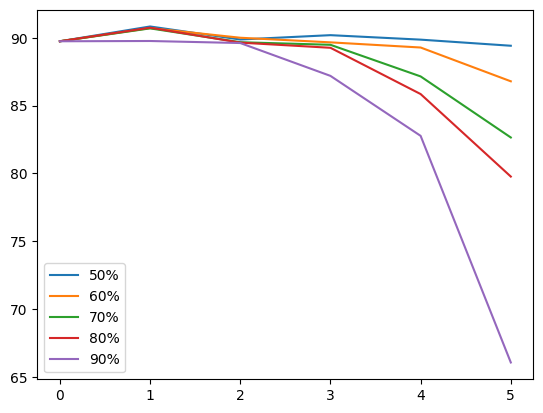

In [89]:
x = list(range(6))

plt.plot(x, make_list(acc_50), label='50%')
plt.plot(x, make_list(acc_60), label='60%')
plt.plot(x, make_list(acc_70), label='70%')
plt.plot(x, make_list(acc_80), label='80%')
plt.plot(x, make_list(acc_90), label='90%')
plt.legend()

plt.show()

### params

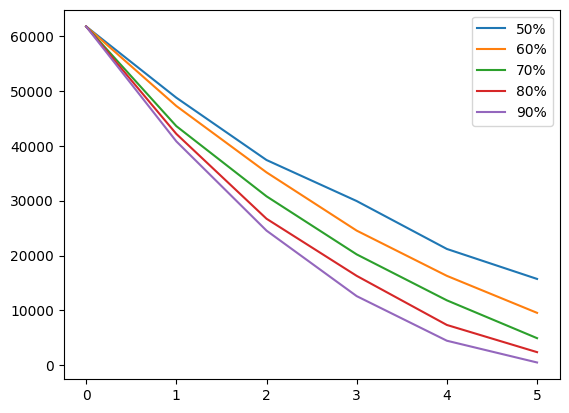

In [81]:
x = list(range(6))

plt.plot(x, params_50, label='50%')
plt.plot(x, params_60, label='60%')
plt.plot(x, params_70, label='70%')
plt.plot(x, params_80, label='80%')
plt.plot(x, params_90, label='90%')
plt.legend()

plt.show()

### MACs

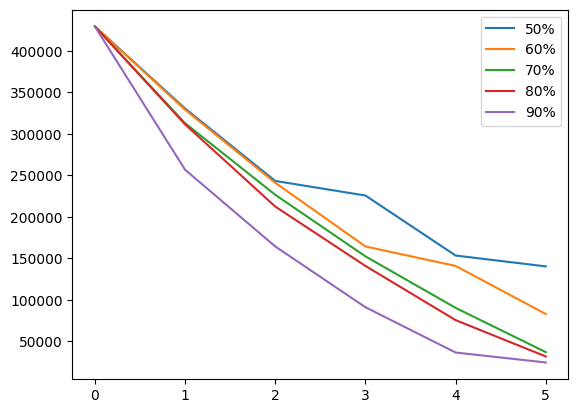

In [90]:
x = list(range(6))

plt.plot(x, mmac_50, label='50%')
plt.plot(x, mmac_60, label='60%')
plt.plot(x, mmac_70, label='70%')
plt.plot(x, mmac_80, label='80%')
plt.plot(x, mmac_90, label='90%')
plt.legend()

plt.show()